In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Markov chain Monte Carlo method for inference of stochastic block models
From the paper [Overview of Peixoto’s Monte Carlo Method for Inference of SBMs](https://www.ricardobatista.com/presentations/Overview%20of%20Peixoto%E2%80%99s%20MC%20Method%20for%20Inference%20of%20SBMs%20%283.21.2018%29.pdf)

### Initializing the graph

In [17]:
sizes = [20, 12, 12] 
probs = [
    [0.45, 0.05, 0.02], 
    [0.05, 0.45, 0.07],
    [0.02, 0.07, 0.6]
]
G = nx.stochastic_block_model(sizes, probs)
A = nx.adjacency_matrix(G).toarray() 


### Initializing the partition
The initial partition is randomly generated. Each node is assigned to a block, and the number of blocks
n_blocks is predefined. This partition is represented by an array where each index corresponds to a node and each value to the block assigned to this node.

In [18]:
n_nodes = len(G.nodes)
n_blocks = 4
current_partition = np.random.choice(n_blocks, n_nodes)

print("Initial partition : ", current_partition)

Initial partition :  [1 3 3 0 3 0 3 1 1 2 2 3 2 0 3 1 3 3 0 0 0 2 3 3 0 2 2 3 1 3 3 3 3 3 1 3 1
 0 0 2 1 3 1 0]


### Modifying the partition

The **propose_new_partition** function generates a new partition by changing the block of a randomly selected node. The node is moved to a different block than the one it currently belongs to, providing variation in the partition structure


In [19]:
def propose_new_partition(partition, n_blocks):
    new_partition = partition.copy()
    node = np.random.randint(n_nodes) 
    current_block = partition[node]
    possible_blocks = list(set(range(n_blocks)) - {current_block})
    new_partition[node] = np.random.choice(possible_blocks)
    return new_partition


### Posteriori probability

The **calculate_posterior** function calculates the posterior probability of the proposed partition, using a simplified SBM model. It counts intra-block and inter-block links. Then, it estimates the probabilities of intra- and inter-block links, and calculates the log-likelihood of the partition based on these probabilities. This value is used to evaluate the quality of the partition in terms of internal consistency of blocks and separation between blocks.


In [20]:
def calculate_posterior(A, partition, n_blocks):
   
    intra_links, inter_links = 0, 0
    total_intra, total_inter = 0, 0

    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):  
            if partition[i] == partition[j]:
                intra_links += A[i][j]
                total_intra += 1
            else:
                inter_links += A[i][j]
                total_inter += 1

    
    p_intra = (intra_links / total_intra) if total_intra > 0 else 0
    p_inter = (inter_links / total_inter) if total_inter > 0 else 0
    epsilon = 1e-10  
    log_likelihood = intra_links * np.log(p_intra + epsilon) + inter_links * np.log(p_inter + epsilon)
    return log_likelihood


### Metropolis-Hastings

If the probability (log-likelihood) of the new partition is higher than that of the current partition, the new partition is accepted with a probability proportional to the exponential of the difference between the new and old log-likelihoods. This allows partitions with better log-likelihood to be accepted almost always, while sometimes allowing transitions to partitions with worse log-likelihood to avoid getting stuck in local minima.


In [21]:
n_iterations = 10000
for i in range(n_iterations):
    new_partition = propose_new_partition(current_partition, n_blocks)
    current_prob = calculate_posterior(A, current_partition, n_blocks)
    new_prob = calculate_posterior(A, new_partition, n_blocks)
    if np.random.random() < np.exp(new_prob - current_prob):
        current_partition = new_partition


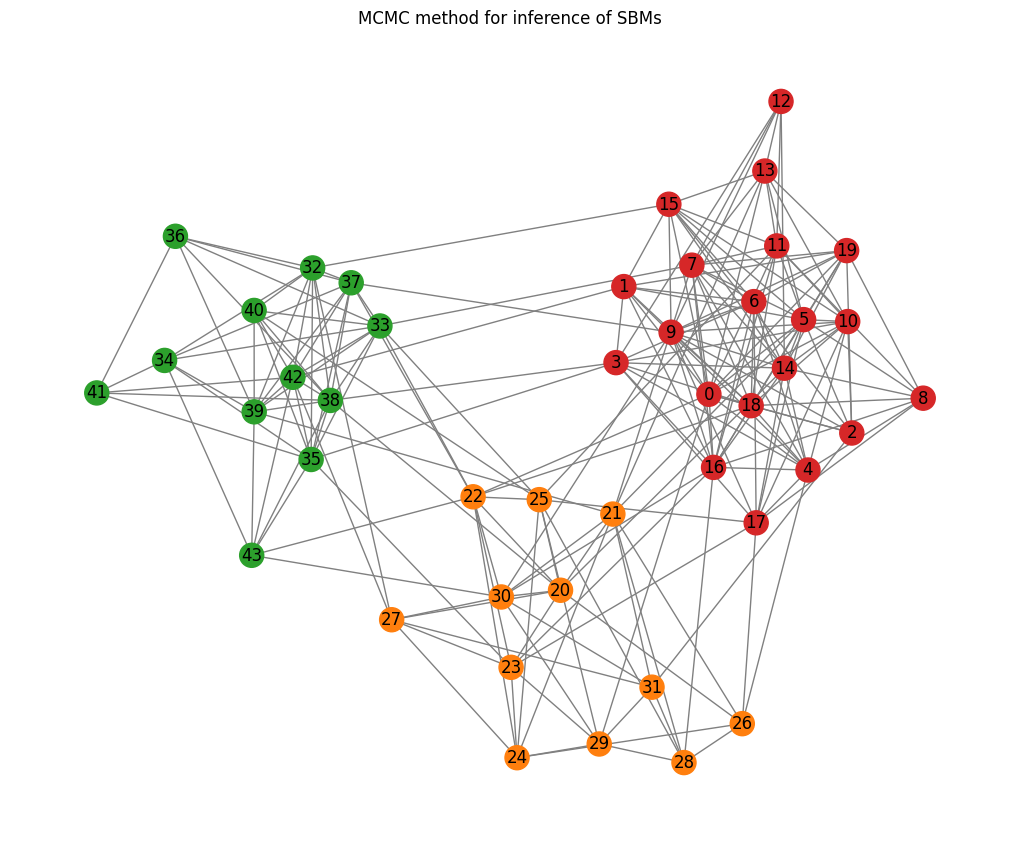

In [22]:
color_map = [f"C{p}" for p in current_partition]
pos = nx.spring_layout(G)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=color_map, with_labels=True, edge_color='gray')
plt.title("MCMC method for inference of SBMs")
plt.show()
